11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] done processing
11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] done processing



📊 Historical Forecast Accuracy (last 18 months):
✅ RMSE: 199,986.86
✅ MAE: 170,170.31
✅ MAPE: 6.35%


11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:06 - cmdstanpy - INFO - Chain [1] done processing


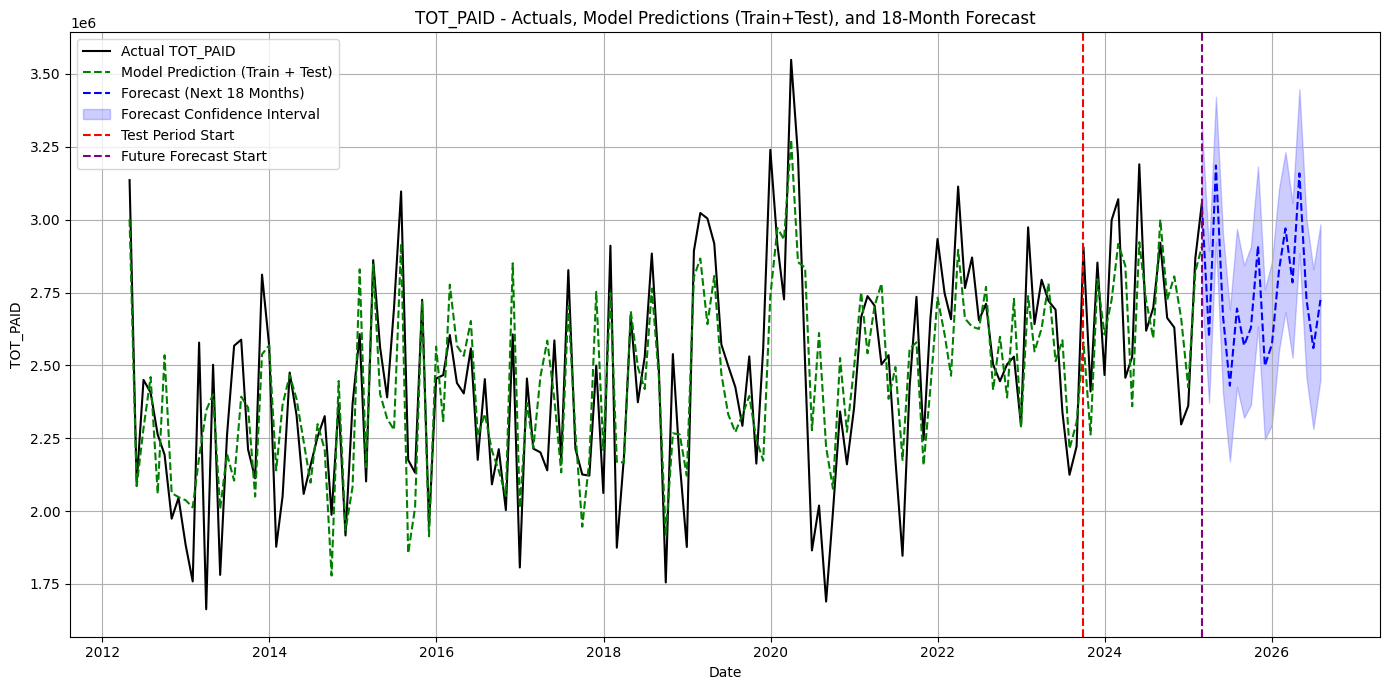

11:04:07 - cmdstanpy - INFO - Chain [1] start processing
11:04:07 - cmdstanpy - INFO - Chain [1] done processing



📈 Plotting Actual + Forecasts for Each Regressor (Only Necessary 6-Month Forecast)...


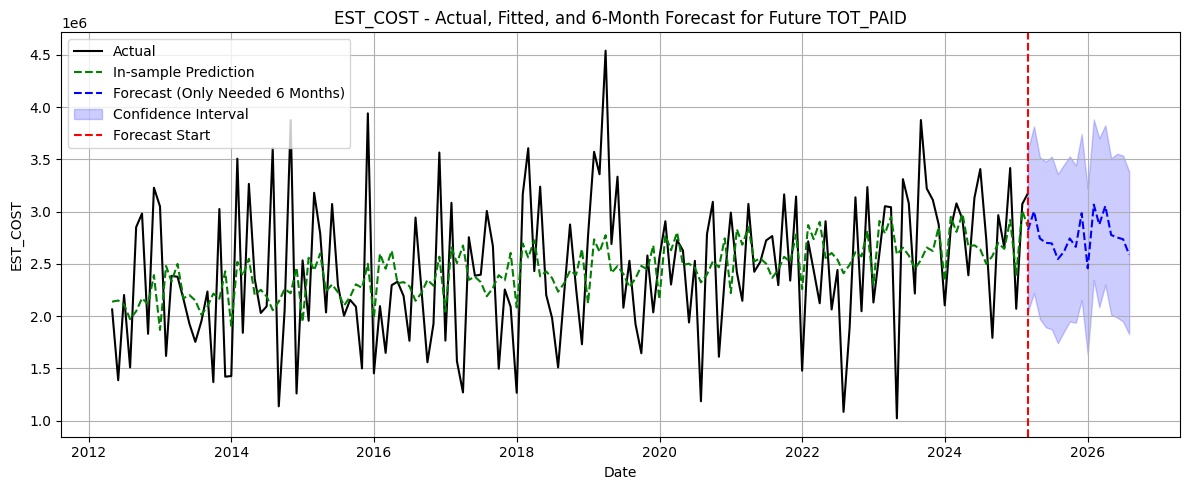

11:04:07 - cmdstanpy - INFO - Chain [1] start processing
11:04:07 - cmdstanpy - INFO - Chain [1] done processing


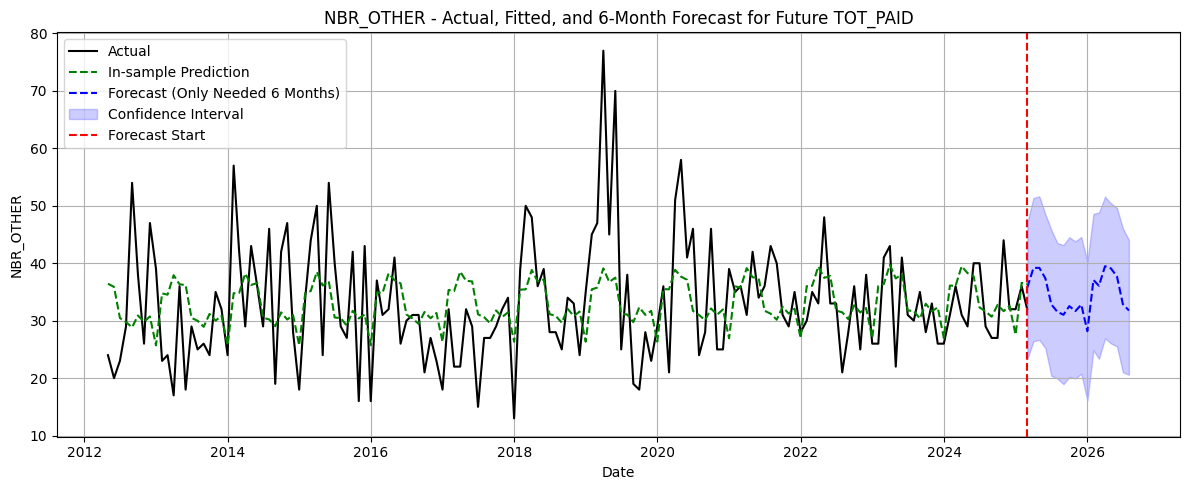


📅 Forecasted TOT_PAID (Next 18 Months):
        ds         yhat   yhat_lower   yhat_upper
2025-03-01 3.044683e+06 2.745800e+06 3.318780e+06
2025-04-01 2.597576e+06 2.370834e+06 2.891557e+06
2025-05-01 3.185864e+06 2.922185e+06 3.421590e+06
2025-06-01 2.668843e+06 2.403566e+06 2.950876e+06
2025-07-01 2.430336e+06 2.170383e+06 2.691500e+06
2025-08-01 2.694999e+06 2.426205e+06 2.968441e+06
2025-09-01 2.568293e+06 2.320407e+06 2.843001e+06
2025-10-01 2.628809e+06 2.364635e+06 2.908235e+06
2025-11-01 2.910329e+06 2.634057e+06 3.182430e+06
2025-12-01 2.498113e+06 2.245765e+06 2.760368e+06
2026-01-01 2.573108e+06 2.295739e+06 2.856087e+06
2026-02-01 2.828050e+06 2.552351e+06 3.106975e+06
2026-03-01 2.969774e+06 2.683962e+06 3.231843e+06
2026-04-01 2.784720e+06 2.525952e+06 3.056107e+06
2026-05-01 3.158813e+06 2.885481e+06 3.447813e+06
2026-06-01 2.725551e+06 2.457705e+06 3.001410e+06
2026-07-01 2.559269e+06 2.281795e+06 2.830231e+06
2026-08-01 2.724571e+06 2.451914e+06 2.983719e+06


In [ ]:
####### repeat the above code with only 2 key regressors##############

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import matplotlib.pyplot as plt

# --- Load and Prepare Data ---
data = pd.read_csv("C:\GitHub\Machine-Learning\data\Payment Data.csv")

# dataset preprocess
data['ACC_MONTH'] = pd.to_datetime(data['ACC_MONTH'])
df = data[['ACC_MONTH', 'TOT_PAID', 'EST_COST', 'NBR_CASE', 'NBR_KEY_CASE','NBR_OTHER']].dropna()

df['ds'] = pd.to_datetime(df['ACC_MONTH'])
df['y'] = df['TOT_PAID']
df = df.sort_values('ds').reset_index(drop=True)


# Step 1: Create 12-month lagged features for selected regressors
lag = 12
regressors = ['EST_COST', 'NBR_OTHER']  # Reduced to just these two

for reg in regressors:
    df[f'{reg}_lag{lag}'] = df[reg].shift(lag)

# Drop NA caused by lag
df_model = df.dropna().copy().reset_index(drop=True)

# Step 2: PCA on lagged features
lagged_features = [f'{reg}_lag{lag}' for reg in regressors]
X = df_model[lagged_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_model['PC1'] = X_pca[:, 0]
df_model['PC2'] = X_pca[:, 1]

# Step 3: Prepare Prophet data
df_model['ds'] = df_model['ds']
df_model['y'] = df_model['y']

# Step 4: Split into train/test (last 18 months for evaluation)
train = df_model[:-18]
test = df_model[-18:]

# Step 5: Fit Prophet model with PC1 & PC2
model = Prophet()
model.add_regressor('PC1')
model.add_regressor('PC2')
model.fit(train[['ds', 'y', 'PC1', 'PC2']])

# Step 6: Evaluate using historical test set
forecast_test = model.predict(test[['ds', 'PC1', 'PC2']])
rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
mae = mean_absolute_error(test['y'], forecast_test['yhat'])

actual = test['y'].values
predicted = forecast_test['yhat'].values
nonzero_mask = actual != 0
actual_nonzero = actual[nonzero_mask]
predicted_nonzero = predicted[nonzero_mask]
mape = np.mean(np.abs((actual_nonzero - predicted_nonzero) / actual_nonzero)) * 100 if len(actual_nonzero) > 0 else np.nan

print("\n📊 Historical Forecast Accuracy (last 18 months):")
print(f"✅ RMSE: {rmse:,.2f}")
print(f"✅ MAE: {mae:,.2f}")
print(f"✅ MAPE: {mape:.2f}%")

# --- PART 2: Forecast Future TOT_PAID using Forecasted Regressors ---

# Step A: Forecast each regressor 30 months ahead (12 extra for lag)
future_regressors = {}
forecast_horizon = 6 

for reg in regressors:
    df_reg = df_model[['ds', reg]].rename(columns={reg: 'y'})
    reg_model = Prophet()
    reg_model.fit(df_reg)
    
    future_dates = reg_model.make_future_dataframe(periods=forecast_horizon + lag, freq='MS')
    reg_forecast = reg_model.predict(future_dates)
    
    future_regressors[reg] = reg_forecast[['ds', 'yhat']].rename(columns={'yhat': f'{reg}_forecast'})

# Step B: Combine regressor forecasts
future_df = future_regressors[regressors[0]].copy()
for reg in regressors[1:]:
    future_df = future_df.merge(future_regressors[reg], on='ds')

# Step C: Apply lag 12 to forecasted features
for reg in regressors:
    future_df[f'{reg}_lag12'] = future_df[f'{reg}_forecast'].shift(12)

# Drop rows with NA from lagging
future_df = future_df.dropna().reset_index(drop=True)

# Step D: PCA on lagged forecasted features
future_X = future_df[[f'{reg}_lag12' for reg in regressors]]
future_X_scaled = scaler.transform(future_X)
future_X_pca = pca.transform(future_X_scaled)
future_df['PC1'] = future_X_pca[:, 0]
future_df['PC2'] = future_X_pca[:, 1]

# Step E: Forecast should start right after last actual data
last_actual_date = df_model['ds'].max()
future_input = future_df[future_df['ds'] > last_actual_date][['ds', 'PC1', 'PC2']].head(18)

# Step F: Forecast TOT_PAID for next 18 months
future_forecast = model.predict(future_input)

# --- Print Forecasted TOT_PAID for Next 18 Months ---
print("\n📅 Forecasted TOT_PAID (Next 18 Months):")
forecast_columns = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
print(future_forecast[forecast_columns].to_string(index=False))


# --- Final Plot: Actuals + Model Prediction (Train + Test) + Forecast ---
# --- Predictions on train set for plotting ---
forecast_train = model.predict(train[['ds', 'PC1', 'PC2']])
forecast_all = pd.concat([forecast_train[['ds', 'yhat']], forecast_test[['ds', 'yhat']]], ignore_index=True)
forecast_all = forecast_all.sort_values('ds').reset_index(drop=True)


plt.figure(figsize=(14, 7))

plt.plot(df_model['ds'], df_model['y'], label='Actual TOT_PAID', color='black')
plt.plot(forecast_all['ds'], forecast_all['yhat'], label='Model Prediction (Train + Test)', color='green', linestyle='--')
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecast (Next 18 Months)', color='blue', linestyle='--')

plt.fill_between(future_forecast['ds'],
                 future_forecast['yhat_lower'],
                 future_forecast['yhat_upper'],
                 color='blue', alpha=0.2, label='Forecast Confidence Interval')

plt.axvline(x=test['ds'].min(), color='red', linestyle='dashed', label='Test Period Start')
plt.axvline(x=future_forecast['ds'].min(), color='purple', linestyle='dashed', label='Future Forecast Start')

plt.title("TOT_PAID - Actuals, Model Predictions (Train+Test), and 18-Month Forecast")
plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Plot Each Regressor: Actual + In-sample Fit + 6-Month Forecast ---
print("\n📈 Plotting Actual + Forecasts for Each Regressor (Only Necessary 6-Month Forecast)...")

for reg in regressors:
    df_reg = df_model[['ds', reg]].rename(columns={reg: 'y'})
    reg_model = Prophet()
    reg_model.fit(df_reg)
    
    # Only forecast 6 + lag months (e.g., 18 months if lag=12)
    future_dates = reg_model.make_future_dataframe(periods=lag + 6, freq='MS')
    forecast = reg_model.predict(future_dates)
    
    plt.figure(figsize=(12, 5))
    plt.plot(df_reg['ds'], df_reg['y'], color='black', label='Actual')
    
    fitted = forecast[forecast['ds'].isin(df_reg['ds'])]
    plt.plot(fitted['ds'], fitted['yhat'], color='green', linestyle='--', label='In-sample Prediction')
    
    forecast_future = forecast[forecast['ds'] > df_reg['ds'].max()]
    plt.plot(forecast_future['ds'], forecast_future['yhat'], color='blue', linestyle='--', label='Forecast (Only Needed 6 Months)')
    
    plt.fill_between(forecast_future['ds'], 
                     forecast_future['yhat_lower'], 
                     forecast_future['yhat_upper'], 
                     color='blue', alpha=0.2, label='Confidence Interval')
    
    plt.axvline(x=df_reg['ds'].max(), color='red', linestyle='dashed', label='Forecast Start')
    plt.title(f"{reg} - Actual, Fitted, and 6-Month Forecast for Future TOT_PAID")
    plt.xlabel("Date")
    plt.ylabel(reg)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()







11:05:53 - cmdstanpy - INFO - Chain [1] start processing
11:05:53 - cmdstanpy - INFO - Chain [1] done processing
11:05:53 - cmdstanpy - INFO - Chain [1] start processing
11:05:53 - cmdstanpy - INFO - Chain [1] done processing



📊 Historical Forecast Accuracy (last 18 months):
✅ RMSE: 199,746.03
✅ MAE: 169,105.84
✅ MAPE: 6.34%


11:05:53 - cmdstanpy - INFO - Chain [1] start processing
11:05:53 - cmdstanpy - INFO - Chain [1] done processing


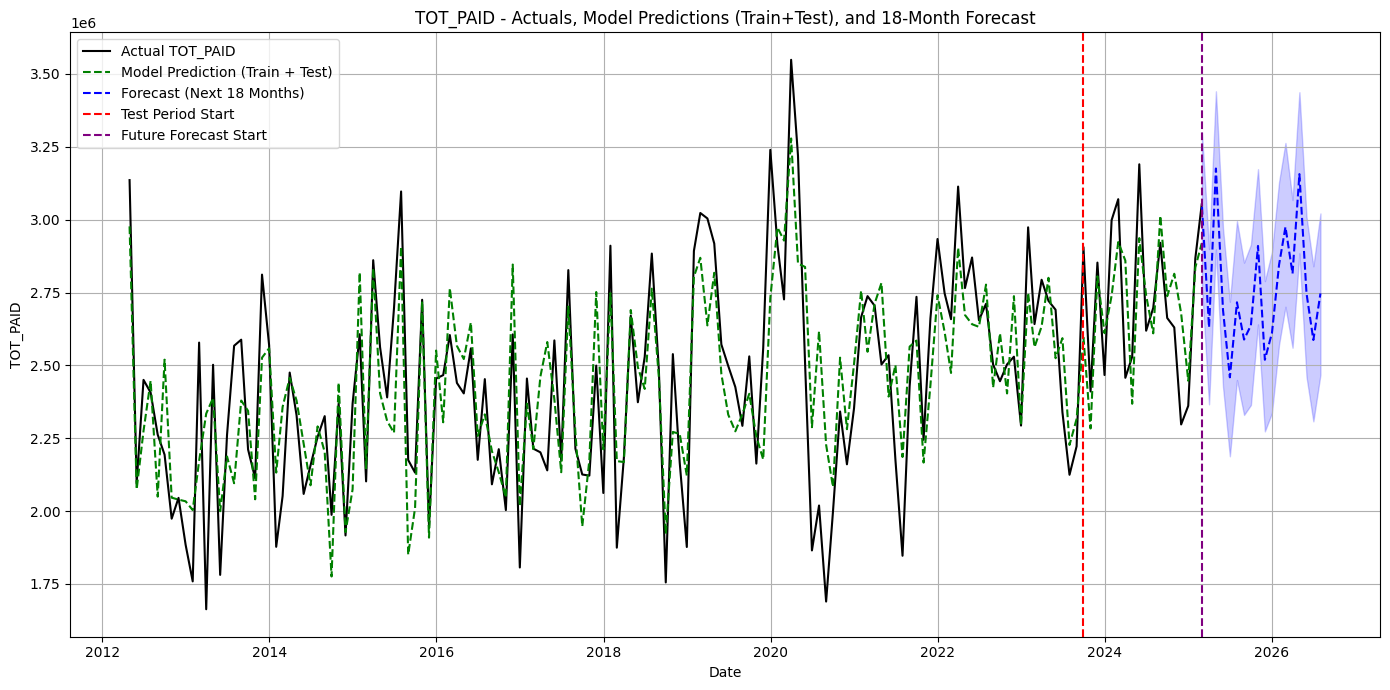


📅 Forecasted TOT_PAID (Next 18 Months):
        ds         yhat   yhat_lower   yhat_upper
2025-03-01 3.043858e+06 2.770287e+06 3.298848e+06
2025-04-01 2.630199e+06 2.366264e+06 2.898952e+06
2025-05-01 3.175403e+06 2.898122e+06 3.440297e+06
2025-06-01 2.689754e+06 2.426333e+06 2.970780e+06
2025-07-01 2.459043e+06 2.188073e+06 2.718243e+06
2025-08-01 2.716406e+06 2.449794e+06 2.995236e+06
2025-09-01 2.588522e+06 2.329959e+06 2.852549e+06
2025-10-01 2.637575e+06 2.364043e+06 2.914512e+06
2025-11-01 2.909796e+06 2.640597e+06 3.173167e+06
2025-12-01 2.519259e+06 2.273456e+06 2.789022e+06
2026-01-01 2.611529e+06 2.336854e+06 2.889318e+06
2026-02-01 2.845081e+06 2.571083e+06 3.128759e+06
2026-03-01 2.974905e+06 2.701174e+06 3.263142e+06
2026-04-01 2.815214e+06 2.560460e+06 3.067192e+06
2026-05-01 3.156273e+06 2.884650e+06 3.437196e+06
2026-06-01 2.747298e+06 2.460716e+06 3.010046e+06
2026-07-01 2.587096e+06 2.307893e+06 2.839941e+06
2026-08-01 2.746986e+06 2.468148e+06 3.021296e+06


In [ ]:
########################### excluding the PCA part and forecasting directly with "EST_COST", and "NBR_OTHER"#################
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import matplotlib.pyplot as plt

# --- Load and Prepare Data ---
# --- Load and Prepare Data ---
data = pd.read_csv("C:\GitHub\Machine-Learning\data\Payment Data.csv")

# dataset preprocess
data['ACC_MONTH'] = pd.to_datetime(data['ACC_MONTH'])
df = data[['ACC_MONTH', 'TOT_PAID', 'EST_COST', 'NBR_CASE', 'NBR_KEY_CASE','NBR_OTHER']].dropna()

df['ds'] = pd.to_datetime(df['ACC_MONTH'])
df['y'] = df['TOT_PAID']
df = df.sort_values('ds').reset_index(drop=True)

# Step 1: Create 12-month lagged features for selected regressors
lag = 12
regressors = ['EST_COST', 'NBR_OTHER']
for reg in regressors:
    df[f'{reg}_lag{lag}'] = df[reg].shift(lag)

# Drop NA caused by lag
df_model = df.dropna().copy().reset_index(drop=True)

# Step 2: Prepare data for Prophet
train = df_model[:-18]
test = df_model[-18:]

# Step 3: Fit Prophet model using lagged regressors
model = Prophet()
for reg in regressors:
    model.add_regressor(f'{reg}_lag{lag}')
model.fit(train[['ds', 'y'] + [f'{reg}_lag{lag}' for reg in regressors]])

# Step 4: Predict on test set
forecast_test = model.predict(test[['ds'] + [f'{reg}_lag{lag}' for reg in regressors]])
rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
nonzero_mask = test['y'] != 0

actual = test['y'].values
predicted = forecast_test['yhat'].values
nonzero_mask = actual != 0
mape = np.mean(np.abs((actual[nonzero_mask] - predicted[nonzero_mask]) / actual[nonzero_mask])) * 100


print("\n📊 Historical Forecast Accuracy (last 18 months):")
print(f"✅ RMSE: {rmse:,.2f}")
print(f"✅ MAE: {mae:,.2f}")
print(f"✅ MAPE: {mape:.2f}%")

# Step 5: Forecast future regressors (only 6 months needed)
future_regressors = {}
forecast_horizon = 6
for reg in regressors:
    df_reg = df_model[['ds', reg]].rename(columns={reg: 'y'})
    reg_model = Prophet()
    reg_model.fit(df_reg)
    future_dates = reg_model.make_future_dataframe(periods=lag + forecast_horizon, freq='MS')
    reg_forecast = reg_model.predict(future_dates)
    future_regressors[reg] = reg_forecast[['ds', 'yhat']].rename(columns={'yhat': f'{reg}_forecast'})

# Step 6: Combine regressor forecasts
future_df = future_regressors[regressors[0]].copy()
for reg in regressors[1:]:
    future_df = future_df.merge(future_regressors[reg], on='ds')

# Step 7: Apply lag 12 to forecasted features
for reg in regressors:
    future_df[f'{reg}_lag{lag}'] = future_df[f'{reg}_forecast'].shift(lag)
future_df = future_df.dropna().reset_index(drop=True)

# Step 8: Forecast should start right after last actual data
last_actual_date = df_model['ds'].max()
future_input = future_df[future_df['ds'] > last_actual_date][['ds'] + [f'{reg}_lag{lag}' for reg in regressors]].head(18)

# Step 9: Forecast TOT_PAID for next 18 months
future_forecast = model.predict(future_input)

# Step 10: Predictions on train set for plotting
forecast_train = model.predict(train[['ds'] + [f'{reg}_lag{lag}' for reg in regressors]])
forecast_all = pd.concat([forecast_train[['ds', 'yhat']], forecast_test[['ds', 'yhat']]], ignore_index=True)
forecast_all = forecast_all.sort_values('ds').reset_index(drop=True)

# Step 11: Plotting
plt.figure(figsize=(14, 7))
plt.plot(df_model['ds'], df_model['y'], label='Actual TOT_PAID', color='black')
plt.plot(forecast_all['ds'], forecast_all['yhat'], label='Model Prediction (Train + Test)', color='green', linestyle='--')
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecast (Next 18 Months)', color='blue', linestyle='--')
plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='blue', alpha=0.2)
plt.axvline(x=test['ds'].min(), color='red', linestyle='dashed', label='Test Period Start')
plt.axvline(x=future_forecast['ds'].min(), color='purple', linestyle='dashed', label='Future Forecast Start')
plt.title("TOT_PAID - Actuals, Model Predictions (Train+Test), and 18-Month Forecast")
plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 12: Print forecasted TOT_PAID
forecast_columns = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
print("\n📅 Forecasted TOT_PAID (Next 18 Months):")
print(future_forecast[forecast_columns].to_string(index=False))
